In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import LeakyReLU,Input,Dense,Flatten,BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD,Adam
import sys ,os

In [2]:
mnist=tf.keras.datasets.mnist
(x_train,y_train),(x_test,y_test)=mnist.load_data()
#map into (-1,1)
x_train,x_test=x_train/255.0*2-1,x_test/255*2-1
print(x_train.shape)


11490434/11490434 [==============================] - 0s 0us/step
(60000, 28, 28)


In [3]:
N,H,W=x_train.shape
D=H*W

x_train=x_train.reshape(-1,D)
x_test=x_test.reshape(-1,D)

In [4]:
#dimensionality of the latent space 
latent_dim=100

In [5]:

#get the generator model
def build_generator(latent_dim):

  i=Input(shape=(latent_dim,))

  x=Dense(256,activation=LeakyReLU(alpha=0.2))(i)
  x=BatchNormalization(momentum=0.8)(x)

  x=Dense(512,activation=LeakyReLU(alpha=0.2))(x)
  x=BatchNormalization(momentum=0.8)(x)

  x=Dense(1024,activation=LeakyReLU(alpha=0.2))(x)
  x=BatchNormalization(momentum=0.8)(x)

  x=Dense(D,activation='tanh')(x)
  model=Model(i,x)
  return model





In [6]:
#discriminator model
def build_discriminator(img_size):
  
  i=Input(shape=(img_size,))
  x=Dense(512,activation=LeakyReLU(alpha=0.2))(i)
  x=Dense(256,activation=LeakyReLU(alpha=0.2))(x)
  x=Dense(1,activation='sigmoid')(x)

  model=Model(i,x)
  return model



In [7]:
#compile both model in preparation for training
#build and compile the discriminator
 
discriminator=build_discriminator(D)
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(0.0002,0.5), 
                      metrics=['accuracy'])

#build and compile the combined model
generator=build_generator(latent_dim)

#create an input to represent noise sample from latent space
z=Input(shape=(latent_dim,))

#pass noise throug generator to get an image
img=generator(z)

#make sure only the generator is trained
discriminator.trainable=False

#the truth ouput is false but we don't label them really
fake_pred=discriminator(img)


#create combined model
combined_model=Model(z,fake_pred)
combined_model.compile(loss='binary_crossentropy', optimizer=Adam(0.0002,0.5), metrics=['accuracy'])

In [8]:
#train the gan
#config
batch_size=32
epochs=10000
sample_period=200#every sample_steps_period steps generate and save some data
 #create batch labels to use when calling train_on_batch

ones=np.ones(batch_size)
zeros=np.zeros(batch_size)

#store the losses
d_losses=[]
g_losses=[]

#create folder to store generated images
if not os.path.exists('gan_images'):
  os.makedirs('gan_images')





In [9]:
#a function to generate a grid of random samples from the generator and save them to a file 
def sample_images(epoch):
  rows,cols=5,5
  noise=np.random.randn(rows*cols,latent_dim)
  imgs=generator.predict(noise)

  #rescale images to 0-1
  imgs=0.5*imgs+0.5
  
  fig,axs=plt.subplots(rows,cols)
  idx=0
  for i in range(rows):
    for j in range(cols):
      axs[i,j].imshow(imgs[idx].reshape(H,W),cmap='gray')
      axs[i,j].axis('off')
      idx+=1
  fig.savefig('gan_images/%d.png'%epoch)
  plt.close()





In [11]:
#main training loop
for epoch in range(epochs):

   ###############################
  ########train discriminator#######
   #select a random batch of image
  idx=np.random.randint(0,x_train.shape[0],batch_size)
  real_imgs=x_train[idx]


  #generate fake images
  noise=np.random.randn(batch_size,latent_dim)
  fake_imgs=generator.predict(noise)

   #train discriminator
  #both losses and accuracy are returned
  d_loss_real,d_acc_real=discriminator.train_on_batch(real_imgs,ones)
  d_loss_fake,d_acc_fake=discriminator.train_on_batch(fake_imgs,zeros)
  d_loss=0.5*(d_loss_real+d_loss_fake)
  d_acc=0.5*(d_acc_real+d_acc_fake)

    #################
 #train generator########

  noise=np.random.randn(batch_size,latent_dim)
  g_loss=combined_model.train_on_batch(noise,ones)


   #save the losses
  d_losses.append(d_loss)
  g_losses.append(g_loss)
  
  if epoch % sample_period==0:
    sample_images(epoch)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 15ms/step


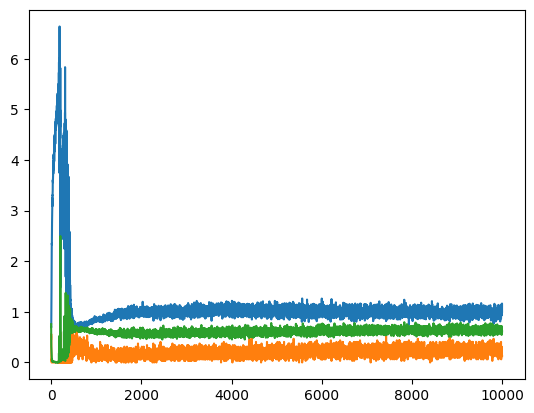

In [12]:
plt.plot(g_losses,label='g_losses')
plt.plot(d_losses,label='d_losses')

In [13]:
!ls gan_images


0.png	  200.png   3400.png  4600.png	6000.png  7200.png  8400.png  9800.png
1000.png  2200.png  3600.png  4800.png	600.png   7400.png  8600.png
1200.png  2400.png  3800.png  5000.png	6200.png  7600.png  8800.png
1400.png  2600.png  4000.png  5200.png	6400.png  7800.png  9000.png
1600.png  2800.png  400.png   5400.png	6600.png  8000.png  9200.png
1800.png  3000.png  4200.png  5600.png	6800.png  800.png   9400.png
2000.png  3200.png  4400.png  5800.png	7000.png  8200.png  9600.png


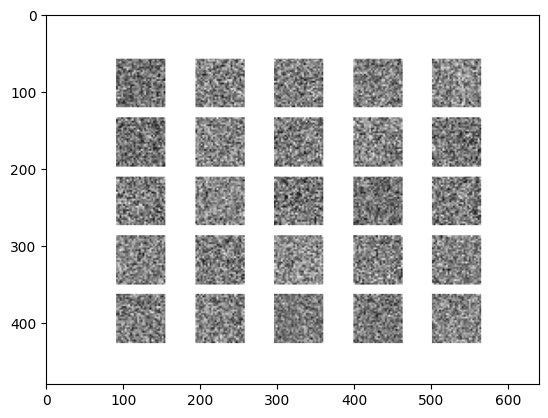

In [14]:
from skimage.io import imread
a=imread('/content/gan_images/0.png')
plt.imshow(a)

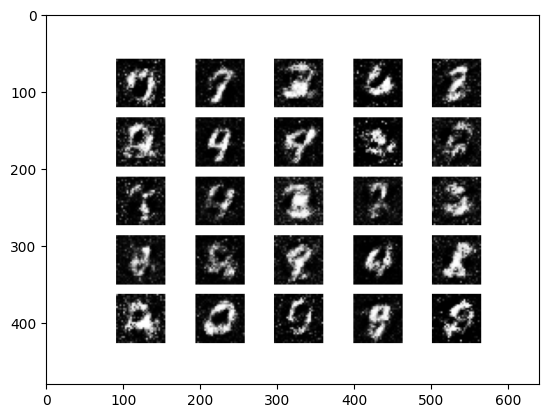

In [15]:
a=imread('gan_images/2400.png')
plt.imshow(a)

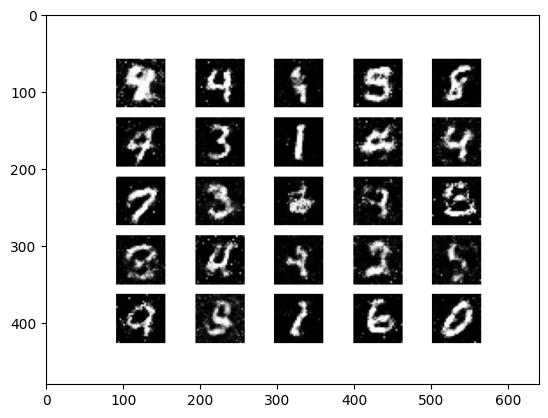

In [16]:
a=imread('gan_images/5200.png')
plt.imshow(a)

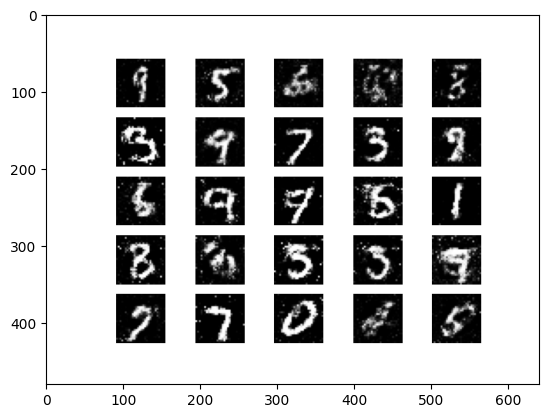

In [17]:
a=imread('gan_images/8200.png')
plt.imshow(a)